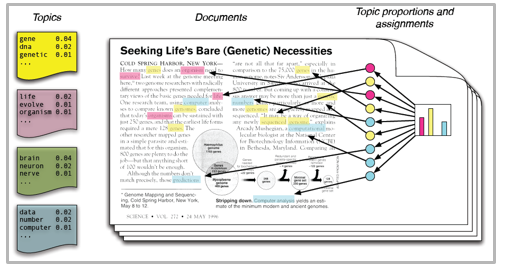

In [1]:
from IPython.display import Image
Image(filename ='E:/PIP_Devmallya/Week_3/Problem_1/Modeling1.png', width = 800, height = 200)

# Problem Statement

    Our task will be to use all of the skills have used in this course to develop a model to determine which subreddit comments originated from. Here you will be given a small dataset with examples of comments posted in different classes.

# Import Dependencies

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import string
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import concurrent.futures
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# Plotly based imports for visualization
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
#!python -m spacy download en_core_web_lg

In [26]:
import re
import nltk
import spacy
from spacy.tokenizer import Tokenizer

# Load the Dataset

In [3]:
df = pd.read_csv('E:/PIP_Devmallya/Week_3/Problem_1/vaccination_all_tweets.csv')
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [4]:
# Creating a spaCy object
nlp = spacy.load('en_core_web_lg')

# Data Preprocessing

In [5]:
df.drop(columns={"id","user_name","user_description","user_created","user_followers", "user_friends","user_favourites","user_verified","hashtags","source","retweets","favorites","is_retweet", "user_location", "date"},inplace=True)
df.head()

,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...


In [6]:
# Drop the duplicates tweets

df = df.drop_duplicates('text')
df.shape

(226373, 1)

In [7]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

In [8]:
df['clean_tweet'] = df.text.apply(remove_links)
df.head()

,text,clean_tweet
0,Same folks said daikon paste could treat a cyt...,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're...","Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...,Explain to me again why we need a vaccine @Bor...


In [9]:
df['clean_tweet'] = df['clean_tweet'].apply(remove_users)
df.head()

,text,clean_tweet
0,Same folks said daikon paste could treat a cyt...,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're...","Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...,Explain to me again why we need a vaccine #w...


In [10]:
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
def clean_tweet(tweet):
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    return tweet

In [11]:
df['clean_tweet'] = df['clean_tweet'].apply(clean_tweet)
df.head()

,text,clean_tweet
0,Same folks said daikon paste could treat a cyt...,same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...,while the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,#coronavirus #sputnikv #astrazeneca #pfizerbio...
3,"Facts are immutable, Senator, even when you're...",facts are immutable senator even when you re n...
4,Explain to me again why we need a vaccine @Bor...,explain to me again why we need a vaccine #whe...


In [12]:
# Removing hastags
import neattext as ntx
df['clean_tweet'] = df['clean_tweet'].apply(ntx.remove_hashtags)
df.head()

,text,clean_tweet
0,Same folks said daikon paste could treat a cyt...,same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...,while the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,russian vaccine is created to las...
3,"Facts are immutable, Senator, even when you're...",facts are immutable senator even when you re n...
4,Explain to me again why we need a vaccine @Bor...,explain to me again why we need a vaccine


In [13]:
df['clean_tweet'][0]

'same folks said daikon paste could treat a cytokine storm   '

In [14]:
df["clean_tweet"] = df["clean_tweet"].apply(lambda x: x.rstrip())
df.head()

,text,clean_tweet
0,Same folks said daikon paste could treat a cyt...,same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...,while the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,russian vaccine is created to las...
3,"Facts are immutable, Senator, even when you're...",facts are immutable senator even when you re n...
4,Explain to me again why we need a vaccine @Bor...,explain to me again why we need a vaccine


In [15]:
df['clean_tweet'][0]

'same folks said daikon paste could treat a cytokine storm'

# Named Entity Recognition

    Named Entity Recognition is a task that finds and categorises named entities in unstructured phrases, such as human names, organisations, places, medical codes, time expressions, amounts, monetary values, percentages, and so on.

In [16]:
doc = nlp(df["clean_tweet"][1])
spacy.displacy.render(doc, style='ent',jupyter=True)

In [17]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

# Parts of Speech tagging

    This is the process of identifying a word in a text (corpus) as belonging to a certain part of speech based on both its definition and its context—that is, its connection with adjacent and related words in a phrase, sentence, or paragraph. A simplified version of this is typically taught to school-age children, in which words are identified as nouns, verbs, adjectives, adverbs, and so on.

In [20]:
# POS tagging
for i in nlp(review):
    print(i,"=>",i.pos_)

while => SCONJ
the => DET
world => NOUN
have => AUX
be => VERB
on => ADP
the => DET
wrong => ADJ
side => NOUN
of => ADP
history => NOUN
this => DET
year => NOUN
hopefully => ADV
the => DET
big => ADJ
vaccination => NOUN
effort => NOUN
we => PRON
ve => VERB
ev => X
… => PUNCT


In [21]:
df.head()

,text,clean_tweet
0,Same folks said daikon paste could treat a cyt...,same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...,while the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,russian vaccine is created to las...
3,"Facts are immutable, Senator, even when you're...",facts are immutable senator even when you re n...
4,Explain to me again why we need a vaccine @Bor...,explain to me again why we need a vaccine


In [22]:
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = list(STOP_WORDS)

def remove_stopwords(tweet):
    tweet_token_list = [word for word in tweet.split(' ') if word not in stopwords]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [29]:
df['clean_tweet'] = df['clean_tweet'].apply(remove_stopwords)
df.head()

,text,clean_tweet
0,Same folks said daikon paste could treat a cyt...,folks said daikon paste treat cytokine storm
1,While the world has been on the wrong side of ...,world wrong history year hopefully biggest vac...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,russian vaccine created years…
3,"Facts are immutable, Senator, even when you're...",facts immutable senator ethically sturdy ackno...
4,Explain to me again why we need a vaccine @Bor...,explain need vaccine


# Topic Modeling

## Vectorizer Creation

In [30]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9)
data_vectorized = vectorizer.fit_transform(df["clean_tweet"])

In [31]:
NUM_TOPICS = 10

In [32]:
# Latent Dirichlet Allocation Model

lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


    Matrix with Non-Negative Values Factorization is a statistical strategy for reducing the dimension of an input corpus or corpus. Internally, it employs the component analysis approach to assign a lower weighting to words that are less coherent.
    1. It is a member of the linear algebra algorithm family that is used to find the latent or hidden structure in data.

    2. It takes the form of a non-negative matrix.

    3. It may also be used for topic modelling, with the term-document matrix as the input, which is normally TF-IDF normalised.

    Number of subjects, Term-Document matrix as input.
    Output: Two non-negative matrices containing the original n-words by k topics and the same k topics by m original documents are returned.
    To put it another way, we use linear algebra to model topics.
    4. NMF's popularity stems from its ability to extract sparse and clearly interpretable variables automatically.
    

In [35]:
# Non-Negative Matrix Factorization Model

nmf = NMF(n_components=NUM_TOPICS)
data_nmf = nmf.fit_transform(data_vectorized)

    Latent semantic indexing (LSI) is an indexing and retrieval approach that use the singular value decomposition (SVD) mathematical methodology to find patterns in the connections between words and concepts in an unstructured collection of text. It has been found that text retrieval may be done utilising the latent semantic indexing (LSI) methodology with shortened singular value decomposition (SVD). The SVD decreases the noise in the term–document matrix's original representation and enhances information retrieval accuracy. According to recent research, SVD is best helpful for small, homogenous data sets. The performance of the SVD-based text retrieval approach may degrade for big inhomogeneous datasets.
    
    It employs the bag of words (BoW) approach to generate a term-document matrix (occurrence of terms in a document). The words are represented by rows, while the documents are represented by columns. Singular value decomposition is used by LSA to discover latent themes by conducting a matrix decomposition on the document-term matrix. LSA is commonly employed as a noise reduction or dimension reduction approach.

In [36]:
# Latent Semantic Indexing Model using Truncated SVD

lsi = TruncatedSVD(n_components=NUM_TOPICS)
data_lsi = lsi.fit_transform(data_vectorized)

In [37]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])

In [38]:
# Keywords for topics clustered by Latent Dirichlet Allocation
print("LDA Model:")
selected_topics(lda, vectorizer)

LDA Model:
Topic 0:
[('vaccine', 13574.305609814466), ('vaccines', 10579.92636209278), ('covid', 9192.056169087251), ('use', 6194.189773895995), ('approved', 5773.960166973939), ('doses', 4706.2239170686025), ('emergency', 4118.785138701481), ('mrna', 3724.3125239290916), ('road', 2706.1825070742607), ('china', 2537.6389587997332)]
Topic 1:
[('free', 14647.09182564671), ('ages', 14141.362476395338), ('availability', 11414.601345948757), ('second', 6524.330010355918), ('apollo', 5668.148190062767), ('booster', 5631.9631189543425), ('vaccine', 5320.672681471384), ('ocgn', 4017.877854522729), ('like', 3962.1458729274354), ('man', 2823.4915299520294)]
Topic 2:
[('vaccinated', 5645.818902478401), ('new', 4107.884684157046), ('sputnik', 3687.6270393703758), ('the', 2412.287501350336), ('cases', 2347.3364327094014), ('news', 2256.0668171813454), ('week', 2149.7909340793544), ('group', 1274.6549861558767), ('variant', 1209.018145274744), ('hos', 1188.2345092656292)]
Topic 3:
[('approval', 6479

In [39]:
# Keywords for topics clustered by Latent Semantic Indexing
print("NMF Model:")
selected_topics(nmf, vectorizer)

NMF Model:
Topic 0:
[('covaxin', 7.560216047181344), ('pincode', 7.244364276708021), ('date', 7.0210175784759645), ('fees', 6.944128058650303), ('age', 6.922668625838135), ('slots', 6.587478443478425), ('ages', 5.437519856378153), ('dose', 5.342141272889597), ('sep', 2.490440601395831), ('aug', 2.319559996960242)]
Topic 1:
[('vaccine', 16.256979775657417), ('india', 0.7432360916868891), ('use', 0.660267167842458), ('moderna', 0.6067447616542093), ('sputnik', 0.5569098795527646), ('approved', 0.5187278367574478), ('russia', 0.39915480081364757), ('emergency', 0.3763026258376511), ('available', 0.3503414663618512), ('doses', 0.336238075665876)]
Topic 2:
[('dose', 11.761296621745728), ('hospital', 1.7453738545902857), ('nd', 1.5137848502495834), ('st', 1.3611285888656828), ('second', 1.0998256045380987), ('road', 0.692413630991958), ('pmc', 0.5020806661955949), ('sec', 0.480094999134285), ('pvt', 0.4176305218329806), ('clinic', 0.37593498397516434)]
Topic 3:
[('slots', 9.928203883874943),

In [40]:
# Keywords for topics clustered by Non-Negative Matrix Factorization
print("LSI Model:")
selected_topics(lsi, vectorizer)

LSI Model:
Topic 0:
[('dose', 0.5508480328652852), ('slots', 0.48925956853418356), ('age', 0.32975027516346644), ('covaxin', 0.2727971528448619), ('pincode', 0.24242814999451437), ('date', 0.23171295668089095), ('fees', 0.22828378396708396), ('ages', 0.17640521684383384), ('free', 0.12643027088645878), ('availability', 0.10258632727269894)]
Topic 1:
[('vaccine', 0.8268653141164858), ('covid', 0.2648686844555552), ('dose', 0.22192267145493277), ('got', 0.12406590922278121), ('today', 0.08473136993152165), ('moderna', 0.08422275887286487), ('doses', 0.08286163889420971), ('second', 0.07951445662587979), ('india', 0.07517543332930486), ('amp', 0.0673819783914077)]
Topic 2:
[('dose', 0.5277697337218084), ('free', 0.261742745014864), ('availability', 0.2609096293472548), ('pm', 0.15991544350624323), ('paid', 0.14327893500790237), ('slots', 0.096108862853196), ('nd', 0.061462305872798106), ('st', 0.052949633898332085), ('second', 0.04766603768346582), ('got', 0.035497237379081344)]
Topic 3:


    In the above three models we are showing the top 10 words of each models from all the 10 topics along with their vectors because by this way we can understand in which topics which words has been documented more.

# Visualizing LDA results with pyLDAvis

In [41]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
dash

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
9      32.420952   8.115230       1        1  12.195474
5       0.648955  71.707100       2        1  11.332515
1      71.019684   9.971006       3        1  10.673043
6       3.785981  33.185135       4        1  10.306510
4     -42.666500  -9.222070       5        1  10.294990
8      -3.621689 -43.526516       6        1  10.203203
0      -3.632402  -4.171708       7        1   9.733658
7     -36.584400  35.804413       8        1   9.267963
3      44.391380  50.615383       9        1   8.246369
2      40.235809 -31.591665      10        1   7.746275, topic_info=              Term          Freq         Total Category  logprob  loglift
3667          dose  58399.000000  58399.000000  Default  30.0000  30.0000
11385        slots  42794.000000  42794.000000  Default  29.0000  29.0000
325            age  27266.000000  27266.000000  Default  28.0000  28.0000
2839       covaxin  24794.000000  24794.000000  Default  27.0000  27.0000
9116       pincode  17073.000000  17073.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
12506        times    611.598923    612.484634  Topic10  -5.2886   2.5565
440          allow    607.913620    608.799371  Topic10  -5.2947   2.5565
13111   vaccinated   6195.789001  10461.382017  Topic10  -2.9731   2.0341
8245          news   2475.834633   3636.191704  Topic10  -3.8904   2.1736
2757   coronavirus    775.574008   1273.010038  Topic10  -5.0511   2.0624

[375 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
9          5  0.999171          aarthi
95        10  0.999030       according
213        2  0.999477    administered
220        7  0.997735  administration
240        8  0.998294          adults
...      ...       ...             ...
13815      9  0.999667            year
13817      5  0.999369           years
13828      6  0.998760             yes
13836      7  0.999286       yesterday
13854      9  0.998974             you

[366 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 2, 7, 5, 9, 1, 8, 4, 3])

In [42]:
data_vectorized

<226373x13944 sparse matrix of type '<class 'numpy.int64'>'
	with 1525419 stored elements in Compressed Sparse Row format>

In [43]:
data_vectorized.shape

(226373, 13944)

In [44]:
len(df)

226373

In [45]:
topic_results = lda.transform(data_vectorized)

In [46]:
topic_results.shape

(226373, 10)

In [47]:
topic_results[0]

array([0.01666667, 0.18333169, 0.01666667, 0.01666667, 0.01666667,
       0.68333497, 0.01666667, 0.01666667, 0.01666667, 0.01666667])

In [48]:
topic_results[0].round(2)

array([0.02, 0.18, 0.02, 0.02, 0.02, 0.68, 0.02, 0.02, 0.02, 0.02])

In [49]:
topic_results[0].argmax()

5

In [50]:
df.head()

,text,clean_tweet
0,Same folks said daikon paste could treat a cyt...,folks said daikon paste treat cytokine storm
1,While the world has been on the wrong side of ...,world wrong history year hopefully biggest vac...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,russian vaccine created years…
3,"Facts are immutable, Senator, even when you're...",facts immutable senator ethically sturdy ackno...
4,Explain to me again why we need a vaccine @Bor...,explain need vaccine


In [51]:
topic_results.argmax(axis=1)

array([5, 3, 4, ..., 8, 0, 8], dtype=int64)

In [52]:
df['Topic'] = topic_results.argmax(axis=1)

In [53]:
df.head(10)

,text,clean_tweet,Topic
0,Same folks said daikon paste could treat a cyt...,folks said daikon paste treat cytokine storm,5
1,While the world has been on the wrong side of ...,world wrong history year hopefully biggest vac...,3
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,russian vaccine created years…,4
3,"Facts are immutable, Senator, even when you're...",facts immutable senator ethically sturdy ackno...,9
4,Explain to me again why we need a vaccine @Bor...,explain need vaccine,4
5,Does anyone have any useful advice/guidance fo...,useful advice guidance covid vaccine safe whil...,4
6,it is a bit sad to claim the fame for success ...,t bit sad claim fame success patriotic compe...,6
7,There have not been many bright days in 2020 b...,bright days best winning,9
8,Covid vaccine; You getting it?\n\n #CovidVacci...,covid vaccine getting,7
9,#CovidVaccine \n\nStates will start getting #C...,states start getting monday says,5


In [54]:
df.to_csv('E:/PIP_Devmallya/Week_3/Problem_1/submissions_2.csv', index = False)
df.head()

,text,clean_tweet,Topic
0,Same folks said daikon paste could treat a cyt...,folks said daikon paste treat cytokine storm,5
1,While the world has been on the wrong side of ...,world wrong history year hopefully biggest vac...,3
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,russian vaccine created years…,4
3,"Facts are immutable, Senator, even when you're...",facts immutable senator ethically sturdy ackno...,9
4,Explain to me again why we need a vaccine @Bor...,explain need vaccine,4
